# Implementation of a KAN-based surrogate  for Model 5
In this notebook I implement a Kolmogorov-Arnold Network (KAN) surrogate model for dynamics 5 and compare it against a neural network of a similar architecture.

## Initialisations

In [ ]:
!python -m venv pykan-env
!source pykan-env/bin/activate  # On Windows use `pykan-env\Scripts\activate`
!pip install pykan==0.0.5
!pip install moviepy --upgrade
!pip install ffmpeg --upgrade
!pip install --upgrade decorator==4.4.2

The virtual environment was not created successfully because ensurepip is not
available.  On Debian/Ubuntu systems, you need to install the python3-venv
package using the following command.

    apt install python3.10-venv

You may need to use sudo with that command.  After installing the python3-venv
package, recreate your virtual environment.

Failing command: /content/pykan-env/bin/python3

/bin/bash: line 1: pykan-env/bin/activate: No such file or directory


In [ ]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

if torch.cuda.is_available():
  %load_ext cudf.pandas
  import cudf
  import cupy as cp
  device = torch.device("cuda")
else:
  import pandas as cudf
  import numpy as cp
  device = torch.device("cpu")

print(device)

cpu


# Data Generation

<h1>Model 5: \begin{cases}\frac{dx_\epsilon}{dt}=-x_\epsilon cos((2\pi+\epsilon cos(10t)) \frac{t}{\epsilon})\\
x_\epsilon(0)=1\end{cases}
Analytical solution: $$
x_0(t)=1$$</h1>

<h1>Parameters:\begin{aligned}
&\Delta t_\epsilon=10^{-3}s\\
&T=10s
\end{aligned}</h1>

## Loading the Dataset

In [ ]:
# Define the differential equation
def dydt(t, x, a):
    return -x * np.cos((t/a) * (2*np.pi + a * np.cos(10*t)))
# Step 1: Generate the dataset
def generate_dataset():
    # Define parameters
    a = 1  # You can adjust this value
    t_values = cp.linspace(0, 10, 10000)  # Generate 100 points between 0 and 10

    # Initialize lists to store results
    t_list = []
    x0_list = []
    xe_list = []
        # Parameters
    x0 = 1  # Initial condition for x
    t_span = (0, 10)  # Time range for the solution
    t_eval = np.linspace(t_span[0], t_span[1], 10000)  # Points at which to store the computed solution

    # Solve the differential equation
    sol = solve_ivp(dydt, t_span, [x0], args=(a,), t_eval=t_eval)

    # Generate the dataset
    t_values = sol.t
    xe_values = sol.y[0]
    x0_values= np.ones_like(t_values)
    # Store the dataset in a pandas DataFrame
    df = cudf.DataFrame({'t': t_values, 'x0': x0_values, 'xe': xe_values})

    # Save the DataFrame to a CSV file
    df.to_csv('dataset.csv', index=False)

    return df

# Step 2: Scale the dataset
def scale_dataset(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[['t', 'x0', 'xe']].to_pandas())
    return cudf.DataFrame(scaled_data, columns=['t', 'x0', 'xe'])

# Step 3: Convert to PyTorch tensors and split into train/test sets
def prepare_tensors(scaled_df):
  # Extract features and target
    features = scaled_df[['t', 'x0']].to_numpy()  # Select only 't' and 'x0' as features
    target = scaled_df['xe'].to_numpy()

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(features, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.float32)

    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)

    # Step 4: Concatenate the data into a single tensor
    train_inputs = torch.empty(0, 2, device=device)
    train_labels = torch.empty(0, dtype=torch.float32, device=device)
    test_inputs = torch.empty(0, 2, device=device)
    test_labels = torch.empty(0, dtype=torch.float32, device=device)

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=1, shuffle=False)

    for data, labels in tqdm(train_loader):
        train_inputs = torch.cat((train_inputs, data.to(device)), dim=0)
        train_labels = torch.cat((train_labels, labels.to(device)), dim=0)

    for data, labels in tqdm(test_loader):
        test_inputs = torch.cat((test_inputs, data.to(device)), dim=0)
        test_labels = torch.cat((test_labels, labels.to(device)), dim=0)

    dataset = {}
    dataset['train_input'] = train_inputs
    dataset['test_input'] = test_inputs
    dataset['train_label'] = train_labels.reshape(-1, 1)
    dataset['test_label'] = test_labels.reshape(-1, 1)

    return dataset

# Generate the dataset
df = generate_dataset()
print("Generated Dataset:")
print(df.head())

# Scale the dataset
scaled_df =df# scale_dataset(df)
print("Scaled Dataset:")
print(scaled_df.head())

# Prepare tensors and split the data
model5_dataset = prepare_tensors(scaled_df)
print("Prepared Dataset:")
print(model5_dataset)


Generated Dataset:
       t   x0        xe
0  0.000  1.0  1.000000
1  0.001  1.0  0.999000
2  0.002  1.0  0.998002
3  0.003  1.0  0.997004
4  0.004  1.0  0.996008
Scaled Dataset:
       t   x0        xe
0  0.000  1.0  1.000000
1  0.001  1.0  0.999000
2  0.002  1.0  0.998002
3  0.003  1.0  0.997004
4  0.004  1.0  0.996008


100%|██████████| 2000/2000 [00:00<00:00, 10787.62it/s]

Prepared Dataset:
{'train_input': tensor([[0.6991, 1.0000],
        [4.4194, 1.0000],
        [3.9554, 1.0000],
        ...,
        [8.5229, 1.0000],
        [0.9391, 1.0000],
        [6.4506, 1.0000]]), 'test_input': tensor([[6.2526, 1.0000],
        [4.6845, 1.0000],
        [1.7312, 1.0000],
        ...,
        [7.8538, 1.0000],
        [1.0951, 1.0000],
        [6.9297, 1.0000]]), 'train_label': tensor([[1.0256],
        [1.0420],
        [0.9653],
        ...,
        [1.0233],
        [0.9888],
        [0.9912]]), 'test_label': tensor([[0.9932],
        [0.9538],
        [1.2957],
        ...,
        [0.9871],
        [0.8832],
        [0.9691]])}


In [ ]:
print("Train data shape: {}".format(model5_dataset['train_input'].shape))
print("Train target shape: {}".format(model5_dataset['train_label'].shape))
print("Test data shape: {}".format(model5_dataset['test_input'].shape))
print("Test target shape: {}".format(model5_dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([8000, 2])
Train target shape: torch.Size([8000, 1])
Test data shape: torch.Size([2000, 2])
Test target shape: torch.Size([2000, 1])


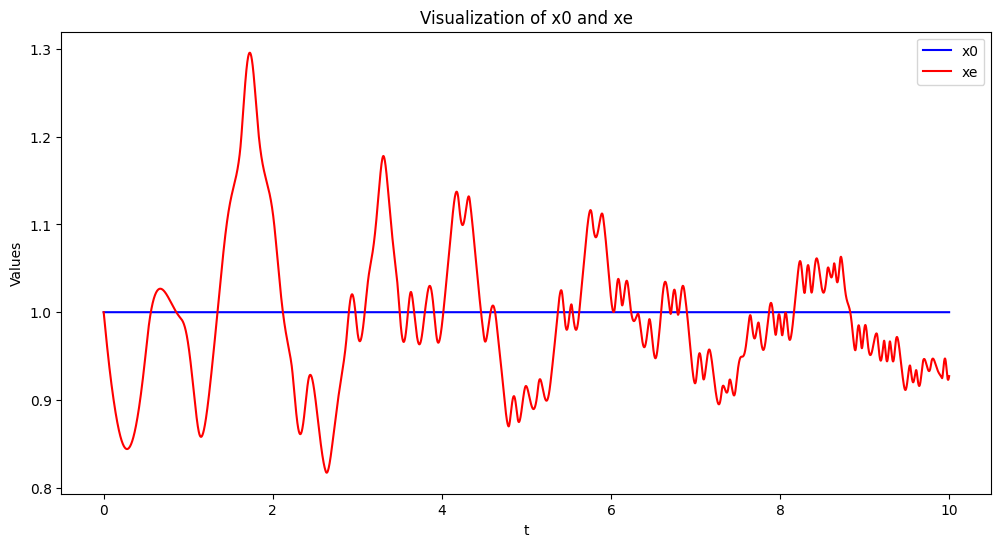

In [ ]:
import matplotlib.pyplot as plt
t = df['t']
x0 = df['x0']
xe = df['xe']

# Plotting x0 and xe
plt.figure(figsize=(12, 6))

# Plot x0
plt.plot(t, x0, label='x0', color='blue')
# Plot xe
plt.plot(t, xe, label='xe', color='red')

# Adding titles and labels
plt.title('Visualization of x0 and xe')
plt.xlabel('t')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()

## Creating and Training the KAN

In [ ]:
image_folder = 'video_img'

kan_model = KAN(width=[2,1, 1], grid=50, k=2, seed=0, device=device)

In [ ]:
def train_mse():
    with torch.no_grad():
        predictions = kan_model(model5_dataset['train_input'])
        mse = torch.nn.functional.mse_loss(predictions, model5_dataset['train_label'])
    return mse

def test_mse():
    with torch.no_grad():
        predictions = kan_model(model5_dataset['test_input'])
        mse = torch.nn.functional.mse_loss(predictions, model5_dataset['test_label'])
    return mse

results = kan_model.train(model5_dataset, opt="LBFGS", device=device, metrics=(train_mse, test_mse),
                      loss_fn=torch.nn.MSELoss(), steps=25, lamb=0.01, lamb_entropy=2., save_fig=True, img_folder=image_folder)

train loss: 3.09e-02 | test loss: 3.07e-02 | reg: 4.77e-01 : 100%|██| 25/25 [00:51<00:00,  2.04s/it]


In [ ]:
print(results['train_mse'][-1], results['test_mse'][-1])

0.0009528581285849214 0.0009415835957042873


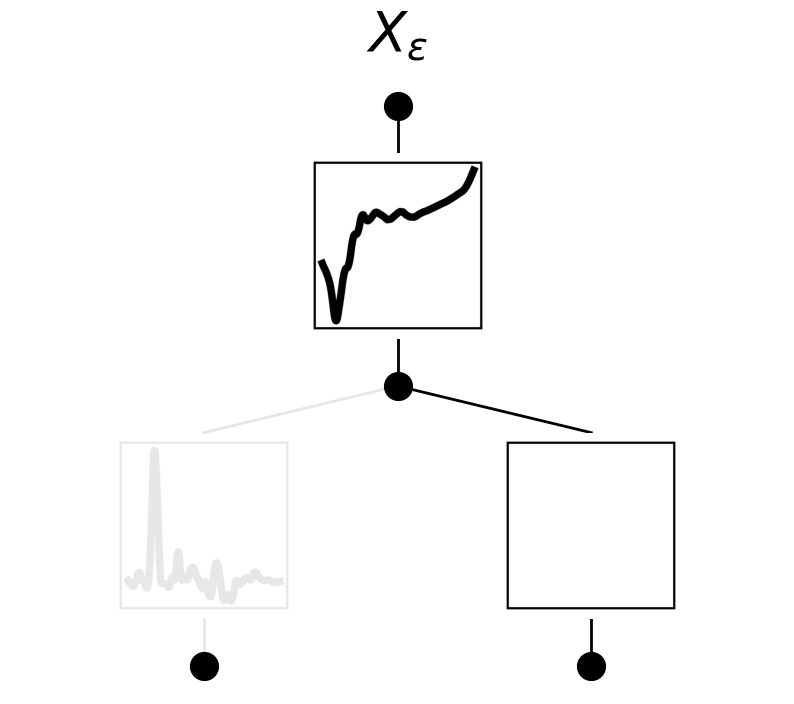

In [ ]:
kan_model.plot(beta=50, scale=1, out_vars=[r'$X_\epsilon$'])

In [ ]:
import moviepy.video.io.ImageSequenceClip

video_name='video'
fps=10
image_folder='/content/video_img'
files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4



Moviepy - Done !
Moviepy - video ready video.mp4


In [ ]:
from IPython.display import HTML
from base64 import b64encode

# Replace 'your_video.mp4' with the filename you uploaded
video_path = '/content/video.mp4'

# Encode video in base64
video = open(video_path, "rb").read()
encoded_video = b64encode(video).decode('utf-8')

# Display video in HTML
video_html = '''
<video width="640" height="480" controls>
  <source src="data:video/mp4;base64,{}" type="video/mp4">
  Your browser does not support the video tag.
</video>
'''.format(encoded_video)

HTML(video_html)


# Implementation of a Neural Network for comparison

## Misc Functions

In [ ]:
class NNet(nn.Module):
    def __init__(self):
        super(NNet, self).__init__()
        self.fc1 = nn.Linear(2, 3)  # 8 inputs to 5 hidden nodes
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(3, 1)  # 5 hidden nodes to 3 outputs

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    total_loss = 0.0
    total_count = 0
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_count += labels.size(0)
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    average_mse = total_loss / total_count
    return average_mse


def test_model(model, test_loader):
    model.eval()
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            outputs = model(inputs)
            loss = torch.nn.functional.mse_loss(outputs, labels, reduction='sum')
            total_loss += loss.item()
            total_count += labels.size(0)

    # Calculate the average MSE over all batches
    average_mse = total_loss / total_count
    print(f'Mean Squared Error: {average_mse}')
    return average_mse

In [ ]:
def load_generated_dataset( test_size=0.2, random_state=42):

    # Extract features and target
    data = df[['t', 'x0']].values
    target = df['xe'].values  # Assuming 'target' is a column in your generated dataset

    # Convert to NumPy arrays if they are CuPy arrays
    if hasattr(data, 'get'):
        data = data.get()
    if hasattr(target, 'get'):
        target = target.get()

    # Scale the features
    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.float32).reshape(-1, 1)

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=test_size, random_state=random_state)

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=200, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=200, shuffle=False)

    return train_loader, test_loader

# Assuming 'dataset.csv' is generated using the provided cuDF/cuPy code
train_loader, test_loader = load_generated_dataset() # removed 'dataset.csv' as it is not used in the function

# Now you can use train_loader and test_loader to train and evaluate your PyTorch models

In [ ]:
dataiter = iter(train_loader)
data, labels = next(dataiter)
print("Train data shape: {}".format(data.shape))
print("Train target shape: {}".format(labels.shape))
dataiter = iter(test_loader)
data, labels = next(dataiter)
print("Test data shape: {}".format(data.shape))
print("Test target shape: {}".format(labels.shape))
print("====================================")

Train data shape: torch.Size([200, 2])
Train target shape: torch.Size([200, 1])
Test data shape: torch.Size([200, 2])
Test target shape: torch.Size([200, 1])


## Train and Evaluate the NN

In [ ]:
model = NNet().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

train_loss=train_model(model, train_loader, criterion, optimizer)

Epoch 1, Loss: 0.00946794729679823
Epoch 2, Loss: 0.005945648066699505
Epoch 3, Loss: 0.007116381544619799
Epoch 4, Loss: 0.006229438818991184
Epoch 5, Loss: 0.005780928768217564
Epoch 6, Loss: 0.008185358718037605
Epoch 7, Loss: 0.005044267047196627
Epoch 8, Loss: 0.007322932593524456
Epoch 9, Loss: 0.005938951391726732
Epoch 10, Loss: 0.008222256787121296
Epoch 11, Loss: 0.006734820548444986
Epoch 12, Loss: 0.0065705496817827225
Epoch 13, Loss: 0.0064842794090509415
Epoch 14, Loss: 0.0071523492224514484
Epoch 15, Loss: 0.006294232793152332
Epoch 16, Loss: 0.006731509696692228
Epoch 17, Loss: 0.007982863113284111
Epoch 18, Loss: 0.0064101130701601505
Epoch 19, Loss: 0.008869608864188194
Epoch 20, Loss: 0.007427439093589783
Epoch 21, Loss: 0.00784554798156023
Epoch 22, Loss: 0.006086060777306557
Epoch 23, Loss: 0.007225822191685438
Epoch 24, Loss: 0.006353212054818869
Epoch 25, Loss: 0.0073541272431612015


In [ ]:
test_loss=test_model(model, test_loader)

Mean Squared Error: 0.007042662084102631


# Comparison

In [ ]:
print("KAN TEST PERFORMANCE :")
print(results['test_mse'][-1])
print("NN TEST PERFORMANCE :")
print(test_loss)

KAN TEST PERFORMANCE :
0.0009415835957042873
NN TEST PERFORMANCE :
0.007042662084102631
